#Import essential lib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Projects/Thesis/Pytorch')

In [ ]:
import early_ar
import AHD

In [ ]:
 pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 12.2 MB/s 


In [ ]:
# Import resources
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from PIL import Image
from collections import OrderedDict
from collections import Counter

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from facenet_pytorch import MTCNN, InceptionResnetV1

from scipy.spatial import distance
import pandas as pd
import os

print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu102
0.10.0+cu102


#Set for Training

In [ ]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('GPU is NOT available')
else:
    print('GPU is AVAILABLE')

# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} GPU detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(f'Multi_GPUs: {multi_gpu}.')
device = torch.device("cuda:0" if train_on_gpu else "cpu")

GPU is AVAILABLE
1 GPU detected.
Multi_GPUs: False.


In [ ]:
data_dir = '/content/drive/MyDrive/Projects/Thesis/data/AR'
train_dir = data_dir + '/train_variation'
train_origin_dir = data_dir + '/train_origin'
test14_dir = data_dir + '/test_14'
test17_dir = data_dir + '/test_17'
test18_dir = data_dir + '/test_18'
test21_dir = data_dir + '/test_21'
test24_dir = data_dir + '/test_24'

In [ ]:
# Define your transforms for the training and testing sets
image_transforms = {
    'train_variation':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # Imagenet standards

    ]),
    'train_origin':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # Imagenet standards

    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

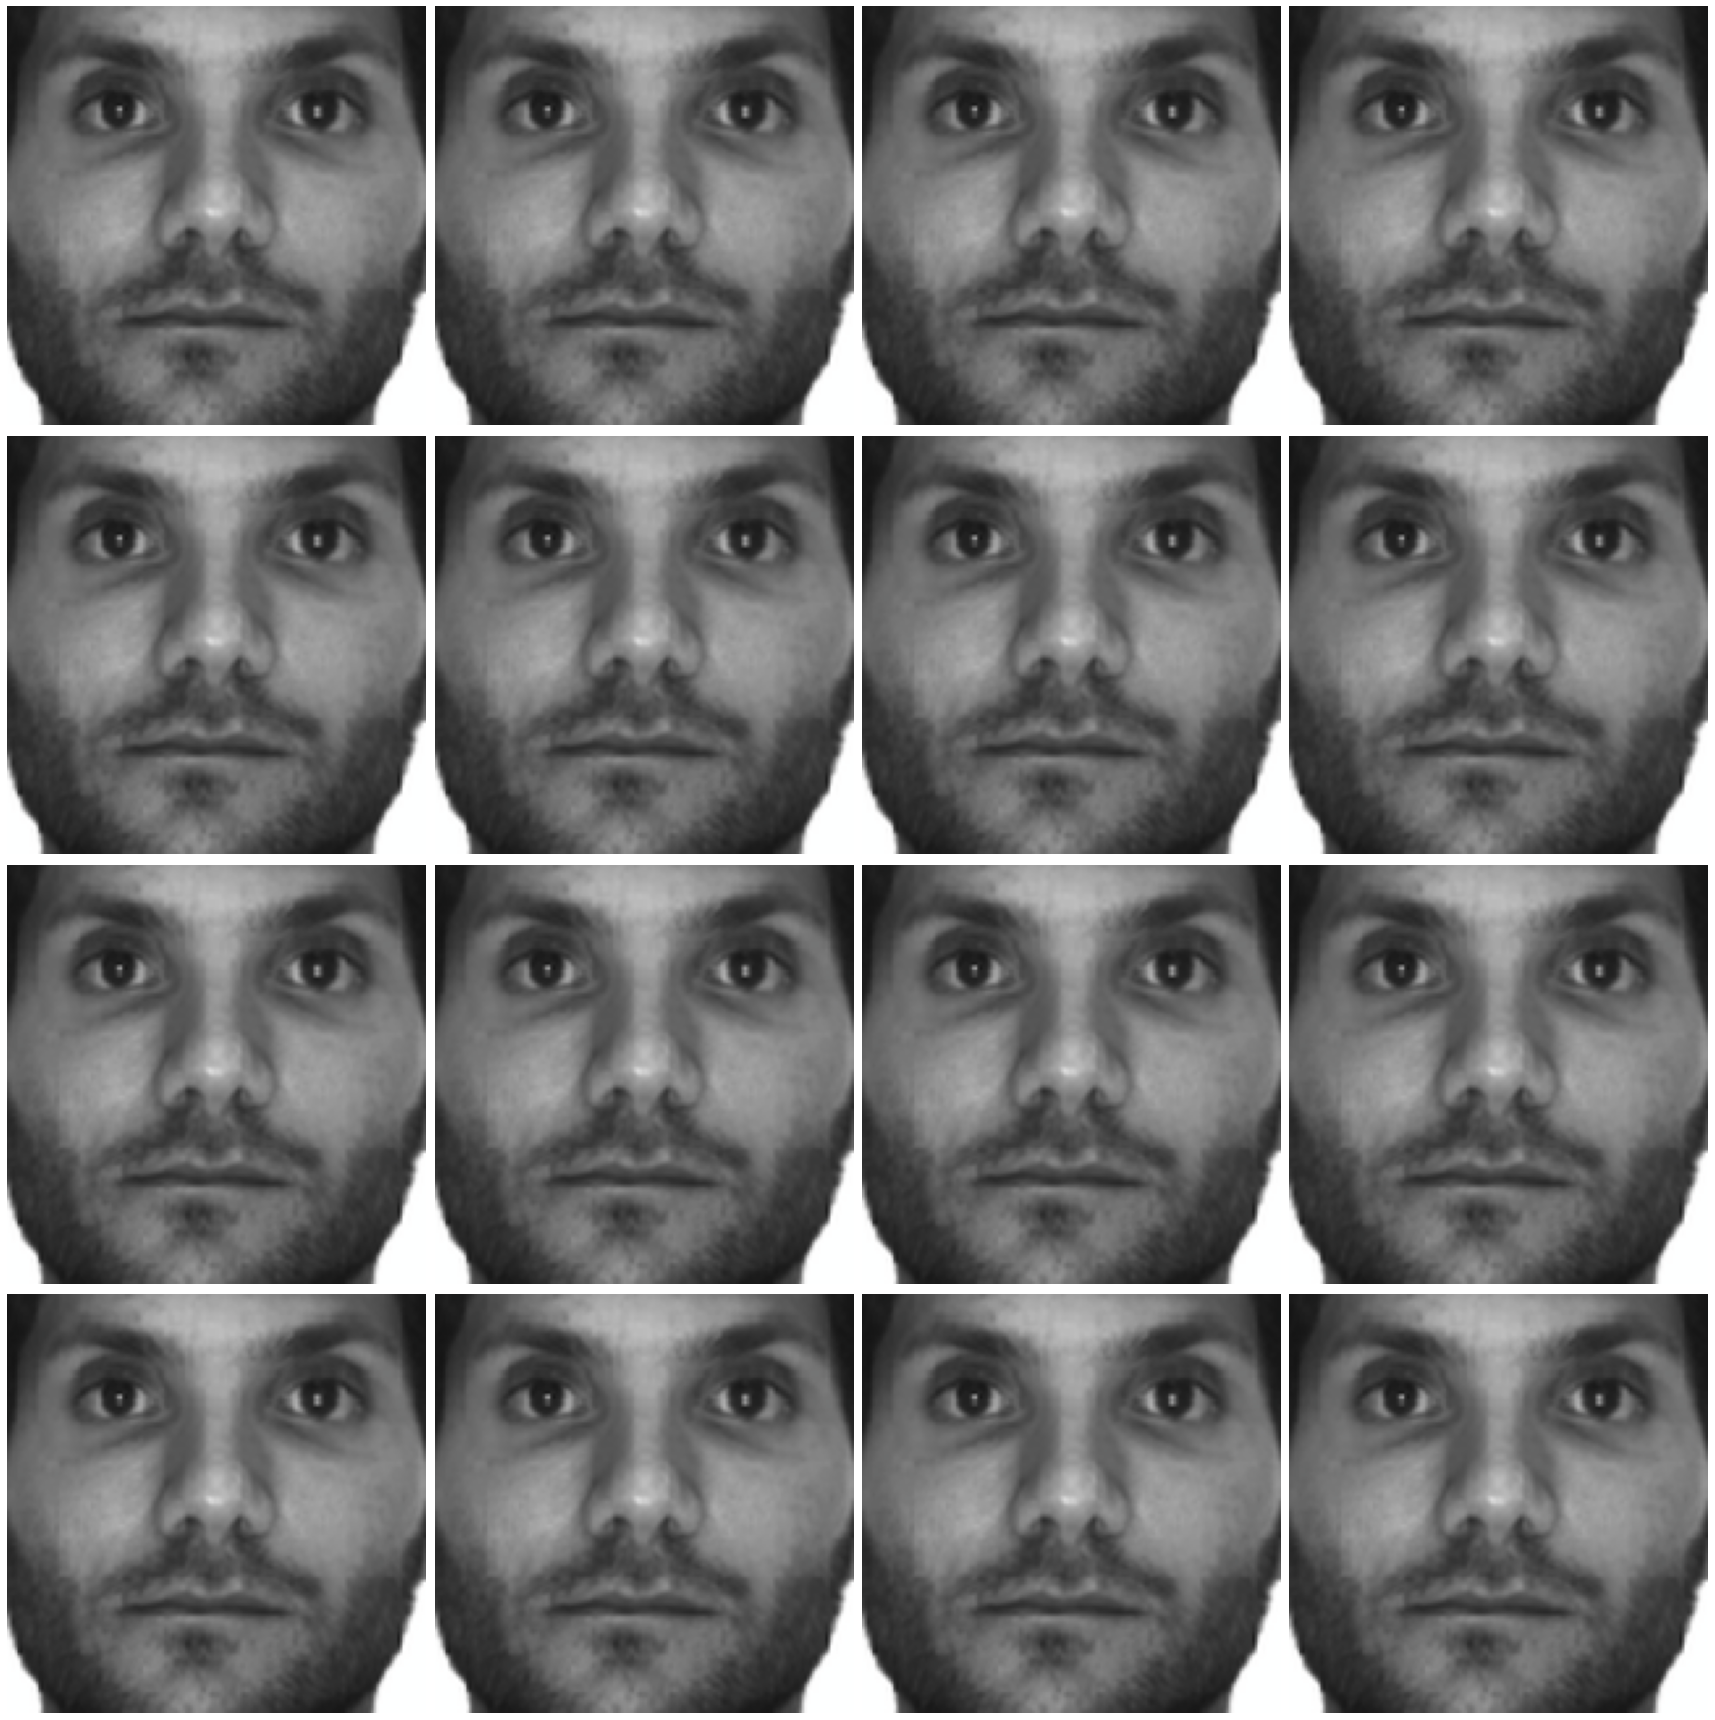

In [ ]:
ex_img = Image.open('/content/drive/MyDrive/Projects/Thesis/data/AR/train_variation/M-005-01/M-005-01.bmp')
ex_img = ex_img.convert('RGB')
t = image_transforms['train_variation']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [ ]:
# Datasets from folders
#batch_size = 100

data = {
    'train_variation': datasets.ImageFolder(root=train_dir, transform=image_transforms['train_variation']),
    'train_origin': datasets.ImageFolder(root=train_origin_dir, transform=image_transforms['train_origin']),
    'test_14': datasets.ImageFolder(root=test14_dir, transform=image_transforms['test']),
    'test_17': datasets.ImageFolder(root=test17_dir, transform=image_transforms['test']),
    'test_18': datasets.ImageFolder(root=test18_dir, transform=image_transforms['test']),
    'test_21': datasets.ImageFolder(root=test21_dir, transform=image_transforms['test']),
    'test_24': datasets.ImageFolder(root=test24_dir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train_variation': DataLoader(data['train_variation'], batch_size=1300, shuffle=True,num_workers=2),
    'train_origin': DataLoader(data['train_origin'], batch_size=100, shuffle=True,num_workers=2),
    'test_14': DataLoader(data['test_14'], batch_size=100, shuffle=True,num_workers=2),
    'test_17': DataLoader(data['test_17'], batch_size=100, shuffle=True,num_workers=2),
    'test_18': DataLoader(data['test_18'], batch_size=100, shuffle=True,num_workers=2),
    'test_21': DataLoader(data['test_21'], batch_size=100, shuffle=True,num_workers=2),
    'test_24': DataLoader(data['test_24'], batch_size=100, shuffle=True,num_workers=2)
}

In [ ]:
dataset_sizes = {x: len(data[x]) for x in ['train_variation', 'train_origin', 'test_14', 'test_17', 'test_18', 'test_21', 'test_24']}
print(dataset_sizes)
print(device)

{'train_variation': 1299, 'train_origin': 100, 'test_14': 100, 'test_17': 100, 'test_18': 100, 'test_21': 100, 'test_24': 100}
cuda:0


In [ ]:
# Iterate through the dataloader once
train_iter = iter(dataloaders['train_variation'])
features, labels = next(train_iter)
features.shape, labels.shape

(torch.Size([1299, 3, 160, 160]), torch.Size([1299]))

In [ ]:
class_names = []
for d in os.listdir(train_dir):
    class_names.append(d)
    
num_out_features = len(class_names)
print(f'There are {num_out_features} different classes. \n{class_names}')

There are 100 different classes. 
['M-001-01', 'M-008-01', 'M-010-01', 'M-005-01', 'M-006-01', 'M-007-01', 'M-003-01', 'M-004-01', 'M-009-01', 'M-002-01', 'M-011-01', 'M-013-01', 'M-017-01', 'M-019-01', 'M-018-01', 'M-012-01', 'M-020-01', 'M-014-01', 'M-016-01', 'M-015-01', 'M-021-01', 'M-022-01', 'M-027-01', 'M-028-01', 'M-023-01', 'M-030-01', 'M-029-01', 'M-031-01', 'M-024-01', 'M-026-01', 'M-025-01', 'M-032-01', 'M-033-01', 'M-039-01', 'M-034-01', 'M-037-01', 'M-041-01', 'M-036-01', 'M-035-01', 'M-040-01', 'M-042-01', 'M-038-01', 'M-043-01', 'M-044-01', 'M-045-01', 'M-048-01', 'W-002-01', 'M-049-01', 'M-046-01', 'W-004-01', 'M-050-01', 'W-001-01', 'W-003-01', 'M-047-01', 'W-005-01', 'W-007-01', 'W-009-01', 'W-013-01', 'W-014-01', 'W-006-01', 'W-010-01', 'W-008-01', 'W-011-01', 'W-012-01', 'W-015-01', 'W-016-01', 'W-019-01', 'W-023-01', 'W-020-01', 'W-025-01', 'W-021-01', 'W-022-01', 'W-018-01', 'W-017-01', 'W-024-01', 'W-035-01', 'W-031-01', 'W-032-01', 'W-027-01', 'W-026-01', 'W-02

In [ ]:
#Load pretrained model
model = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = num_out_features)

In [ ]:
list(model.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [ ]:
layer_list = list(model.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [ ]:
model = nn.Sequential(*list(model.children())[:-5])

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [ ]:
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [ ]:
model.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model.logits = nn.Linear(layer_list[4].in_features, len(class_names))
model.softmax = nn.Softmax(dim=1)

In [ ]:
criterion = AHD.AveragedHausdorffLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#Load The Checkpoint

In [ ]:
PATH = '/content/drive/MyDrive/Projects/Thesis/Pytorch/weight/AR_vggface2.pth'
#Load checkpoint
def load_checkpoint(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    history = checkpoint['history']

    return model, loss, epoch, history 

model, loss, epoch, history = load_checkpoint(PATH)

In [1]:
#print(f'loss_min: {loss} at epoch {epoch} \nhistory: {history}')

# Visualization

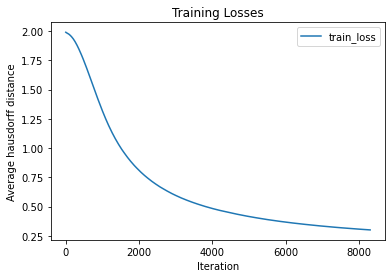

In [ ]:
#plt.figure(figsize=(10,5))
plt.title('Training Losses')
plt.plot(history, label='train_loss')
plt.xlabel('Iteration')
plt.ylabel('Average hausdorff distance')
plt.legend()
plt.show()

#Evaluation

###Learning Similarity

In [ ]:
for data_train, labels_train in dataloaders['train_origin']:
    data_train = data_train.to(device)
    labels_train = labels_train.to(device)
    outputs_train = model(data_train)
print('{} \n{}'.format(outputs_train, labels_train))

In [ ]:
model.eval()
with torch.no_grad():
    for data_test, labels_test in dataloaders['test_14']:
        data_test = data_test.to(device)
        labels_test = labels_test.to(device)
        outputs_test = model(data_test)

print('{} \n{}'.format(outputs_test, labels_test))

In [ ]:
def recognition_euclid(outputs_train, outputs_test, labels_train, labels_test):
    count = 0
    min_dis = np.Inf
    for i,v in enumerate(outputs_test):
        for j,k in enumerate(outputs_train):
            dist = torch.norm(v - k)
            if dist < min_dis:
                min_dis = dist
                indx = labels_train[j]
        #print('min_dis: {:.7f} \n{} - {}'.format(min_dis, labels_test[i], indx))
        if indx == labels_test[i]:
            count += 1
    return count
result = recognition_euclid(outputs_train, outputs_test, labels_train, labels_test)
print('number of right recognition: ', result)

### Nearest Neighbor

In [ ]:
model.to(device)
model.eval()
for data, labels in dataloaders['train_variation']:
    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
print('{} \n{}'.format(outputs.size(), labels.size()))

torch.Size([1299, 100]) 
torch.Size([1299])


In [ ]:
with torch.no_grad():
    for data_test, labels_test in dataloaders['test_17']:
        data_test = data_test.to(device)
        labels_test = labels_test.to(device)
        outputs_test = model(data_test)

print('{} \n{}'.format(outputs_test, labels_test))

tensor([[1.7057e-04, 1.0864e-05, 1.4659e-05,  ..., 6.6753e-06, 4.0314e-04,
         6.4073e-02],
        [3.1541e-04, 6.5292e-05, 4.8440e-05,  ..., 1.3330e-05, 1.0942e-02,
         1.4220e-01],
        [1.6887e-05, 1.5553e-04, 1.8039e-05,  ..., 2.4217e-05, 7.4913e-06,
         4.2100e-02],
        ...,
        [3.1255e-06, 1.8271e-05, 2.4057e-07,  ..., 8.1659e-08, 1.0105e-05,
         1.8551e-03],
        [2.4613e-05, 7.2003e-05, 9.2366e-06,  ..., 1.8467e-05, 4.4395e-06,
         6.7557e-04],
        [5.0169e-07, 2.7668e-05, 8.7717e-07,  ..., 7.6272e-06, 3.6720e-07,
         3.9472e-04]], device='cuda:0') 
tensor([40, 42, 88, 17, 75,  9, 57, 14, 70, 73, 96, 97, 91, 33, 20, 12, 99, 95,
        10, 58, 36, 18, 63, 77, 13, 93, 98, 23, 27, 31, 84, 32, 61, 19, 90, 35,
        68, 44, 15,  7, 11, 76, 41,  3, 89, 46, 81, 67, 37, 72, 62, 26, 53, 65,
        29,  1, 79, 48, 51, 24, 16, 66, 38, 50, 45, 86,  2, 30, 49, 80, 83,  0,
        60, 28, 69,  8,  6, 47, 85, 39, 34, 22, 94, 54,  5, 64, 59

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors = 1)
model_knn.fit(outputs.tolist(), labels.tolist())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn_pred = model_knn.predict(outputs_test.tolist())
print(knn_pred)

[55 16 67 33 75  9 56 14 70 73 96 97 66 24 46 81 45 43 68 64 24 19 57 23
 60 93 98 26 26 31 84 29 49 41 90 35 66 19 15  7 36 76 41 88 61 11 88 16
 39 14 52 37 51 57 33  1 74 17 27 63 36 61 65 83 45 66 59 57 49 84 62  0
 56 21 59 24  6 47 83 18 45 34 63 74  5 45 68 51 74 27 40 62 59 45 70 20
 25 70 74 92]


In [ ]:
from sklearn.metrics import accuracy_score
count_knn = 0
for i in range(100):
  if knn_pred[i] == labels_test[i]:
    count_knn += 1
print('Right Recognition: {} : {}% '.format(count_knn, 100*accuracy_score(labels_test.tolist(), knn_pred)))

Right Recognition: 27 : 27.0% 


### SVM Classifier

In [ ]:
from sklearn import svm, metrics
model_svm = svm.LinearSVC() 
model_svm.fit(outputs.tolist(), labels.tolist())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
svm_pred = model_svm.predict(outputs_test.tolist())
print(svm_pred)

[88 24 31 58 80 31 19 19 31 24 58 58 31 31 24 31 31 24 31 31 31 31 31 84
 31 31 31 31 31 31 19 31 93 31 31 31 31 31 31 24 19 31 31 93 31 31 93 18
 31  0 14 31 31 24 31 14 31 71 31 14 93 24 31 31 24 80 31  0 31 31 31 55
 31 75 31 24 19 32 24 31 58 31 31 31 31 31 31 19 24 31 24 31 31 19 31 31
 31 71 93 15]


In [ ]:
from sklearn.metrics import accuracy_score
count_svm = 0
for i in range(100):
  if svm_pred[i] == labels_test[i]:
    count_svm += 1
print('Right Recognition: {} : {}% '.format(count_svm, 100*accuracy_score(labels_test.tolist(), svm_pred)))

Right Recognition: 1 : 1.0% 
